In [1]:
import csv
import requests
import re
import pdfplumber
import nltk
import os
#import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
#from transformers import BertTokenizer, BertModel
#from sklearn.decomposition import PCA







# 1. Extract the Data

### 1.1 Download the CSV and TXT files

In [ ]:
# download the data from 2021-01-01 to 2024-06-04
%run scrape_convert.py get-metadata --from 2021-01-01 --to 2024-06-04
%run scrape_convert.py download-and-convert-decisions

In [ ]:
# download the data from 2017-01-01 to 2020-12-31
%run scrape_convert.py get-metadata --from 2017-01-01 --to 2020-12-31
%run scrape_convert.py download-and-convert-decisions

In [ ]:
# download the data from 2016-01-01 to 2016-12-31
%run scrape_convert.py get-metadata --from 2016-01-01 --to 2016-12-31
%run scrape_convert.py download-and-convert-decisions

In [ ]:
# download the data from 2015-01-01 to 2015-12-31
%run scrape_convert.py get-metadata --from 2015-01-01 --to 2015-12-31
%run scrape_convert.py download-and-convert-decisions

In [2]:
# combine the four CSV files
def merge_csv_files(output_file: str, *input_files: str):
    if not input_files:
        raise ValueError("No input files provided")

    headers = None
    rows = []

    for input_file in input_files:
        with open(input_file, 'r', newline='', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            if headers is None:
                headers = reader.fieldnames
            elif reader.fieldnames != headers:
                raise ValueError(f"CSV file {input_file} has different headers")
            rows.extend(list(reader))

    with open(output_file, 'w', newline='', encoding='utf-8') as out:
        writer = csv.DictWriter(out, fieldnames=headers)
        writer.writeheader()
        writer.writerows(rows)

# Paths to the input and output files
file1 = "insurance_2021_2024.csv"
file2 = "insurance_2017_2020.csv"
file3 = "insurance_2016_2016.csv"
file4 = "insurance_2015_2015.csv"
output_file = "insurance_2015_2024.csv"

# Merge the files
merge_csv_files(output_file, file1, file2, file3, file4)

print(f"Files {file1}, {file2}, {file3}, and {file4} have been merged into {output_file}.")


Files insurance_2021_2024.csv, insurance_2017_2020.csv, insurance_2016_2016.csv, and insurance_2015_2015.csv have been merged into insurance_2015_2024.csv.


In [3]:
# check for duplicates in the CSV file and whether all TXT files have been downloaded
def get_decision_ids_from_csv(csv_file):
    with open(csv_file, 'r', newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        return {row['decision_id'].strip().lower() for row in reader}

def get_txt_filenames(directory):
    return {file.stem.strip().lower() for file in Path(directory).glob("*.txt")}

def find_missing_decision_ids(csv_file, directory):
    decision_ids = get_decision_ids_from_csv(csv_file)
    txt_filenames = get_txt_filenames(directory)
    missing_decision_ids = decision_ids - txt_filenames
    return missing_decision_ids

def check_duplicates_in_csv(csv_file):
    with open(csv_file, 'r', newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        decision_ids = [row['decision_id'].strip().lower() for row in reader]
    duplicates = {x for x in decision_ids if decision_ids.count(x) > 1}
    return duplicates

# Paths to the CSV file and the directory containing the txt files
csv_file = "insurance_2015_2024.csv"
directory = "insurance_txt"

# Check for duplicates
duplicates = check_duplicates_in_csv(csv_file)

if duplicates:
    print("The following decision_ids are duplicates in the CSV file:")
    for decision_id in duplicates:
        print(decision_id)
else:
    print("No duplicate decision_ids found in the CSV file.")

# Find missing decision_ids
missing_decision_ids = find_missing_decision_ids(csv_file, directory)

if missing_decision_ids:
    print("The following decision_ids are missing their corresponding txt files:")
    for decision_id in missing_decision_ids:
        print(decision_id)
else:
    print("All decision_ids have their corresponding txt files.")


The following decision_ids are duplicates in the CSV file:
drn-1603006
drn4399639
All decision_ids have their corresponding txt files.


In [4]:
# delete duplicate rows in the CSV
def find_and_remove_first_decision_id(csv_file, decision_id_to_find):
    # Read all rows from the CSV file
    with open(csv_file, 'r', newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        rows = list(reader)
        fieldnames = reader.fieldnames

    # Find the index of the first occurrence of the target decision_id
    target_row_index = None
    for i, row in enumerate(rows):
        if row['decision_id'].strip().lower() == decision_id_to_find.lower():
            target_row_index = i
            break

    if target_row_index is not None:
        # Remove the target row
        del rows[target_row_index]
        print(f"Removed first occurrence of decision_id {decision_id_to_find} from row {target_row_index + 1}.")
    else:
        print(f"The decision_id {decision_id_to_find} was not found in the CSV file.")
        return

    # Write the remaining rows back to the CSV file
    with open(csv_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

# Path to the CSV file
csv_file = "insurance_2015_2024.csv"
decision_id_to_find_1 = "drn-1603006"
decision_id_to_find_2 = "drn4399639"

# Find and remove the first occurrence of the decision_id
find_and_remove_first_decision_id(csv_file, decision_id_to_find_1)
find_and_remove_first_decision_id(csv_file, decision_id_to_find_2)


Removed first occurrence of decision_id drn-1603006 from row 29808.
Removed first occurrence of decision_id drn4399639 from row 57421.


### 1.2 Add the insurance types to the CSV

In [2]:
# set up the path
TEXT_DIR = Path("insurance_txt")
CSV_FILE = "insurance_2015_2024.csv"

In [6]:
## Extract the first paragraph

# define the edn markers
end_markers = ["what happened", "background"]

def extract_text_before_markers(text, end_markers):
    """
    extrct the text before the end markers
    """
    end_idx = len(text)
    for marker in end_markers:
        marker_idx = text.lower().find(marker)
        if marker_idx != -1:
            end_idx = min(end_idx, marker_idx)
    return text[:end_idx].strip()

# set up the lists to store txt names and extracted texts.
first_para = []
name_first_para = []

# loop through all text files in insurance_txt and extract the text before the end markers
for txt_file_path in TEXT_DIR.iterdir():
    if txt_file_path.suffix != '.txt':
        continue

    with open(txt_file_path, 'r', encoding='utf-8') as f:
        text_content = f.read()

    # extract the text
    extracted_text = extract_text_before_markers(text_content, end_markers)
    # if there is no end marker in the file, extract the full text
    if not extracted_text:  
        extracted_text = text_content.strip()  

    first_para.append(extracted_text)
    name_first_para.append(txt_file_path.stem)

print(f"Processed {len(first_para)} files.")


Processed 63732 files.


In [7]:
# extract two words before the specified phrase
def extract_word_before_phrase(text, phrase, num_words=2):
    """
    Extract a specified number of words before a specified phrase.
    """
    pattern = rf'((?:\w+\s+){{{num_words}}}){re.escape(phrase)}'
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return None

# remove punctuation
def remove_punctuation(text):
    """
    Remove all punctuation from the text.
    """
    return re.sub(r'[^\w\s]', '', text)

# remove stop words
def remove_stopwords(text):
    """
    Remove stop words
    """
    stopwords = {'that', 'his', 'her', 'a', 'with', 'by', 'as', 'about', 'are', 'their', 'and', 'about'}
    words = text.split()
    meaningful_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(meaningful_words)

# extract and classify insurance types
insurance_types = []
for text in first_para:
    insurance_type = extract_word_before_phrase(text, "insurance policy")
    if not insurance_type:
        insurance_type = extract_word_before_phrase(text, "policy")
    if not insurance_type:
        insurance_type = extract_word_before_phrase(text, "insurance")
    if not insurance_type:
        insurance_type = "NAN"
    
    # remove the punctuation
    insurance_type = remove_punctuation(insurance_type)
    
    # remove stop words
    insurance_type = remove_stopwords(insurance_type)
    
    # classify insurance types
    original_insurance_type = insurance_type  
    if "motor" in insurance_type.lower():
        insurance_type = "motor"
    elif "home" in insurance_type.lower():
        insurance_type = "home"
    elif "bicycle" in insurance_type.lower():
        insurance_type = "bicycle"
    elif "property" in insurance_type.lower():
        insurance_type = "property"
    elif "pet" in insurance_type.lower():
        insurance_type = "pet"
    elif "life" in insurance_type.lower():
        insurance_type = "life"
    elif "car" in insurance_type.lower():
        insurance_type = "car"
    elif "travel" in insurance_type.lower():
        insurance_type = "travel"
    elif "lei" in insurance_type.lower():
        insurance_type = "legal expenses"
    elif "buildings" in insurance_type.lower():
        insurance_type = "buildings"
    elif "gadget" in insurance_type.lower():
        insurance_type = "gadget"
    elif "valuables" in insurance_type.lower():
        insurance_type = "valuables"
    elif "landlords" in insurance_type.lower() or "landlord" in insurance_type.lower():
        insurance_type = "landlords"
    elif "medical" in insurance_type.lower():
        insurance_type = "medical"
    elif "wellwoman" in insurance_type.lower():
        insurance_type = "wellwoman"
    else:
        insurance_type = original_insurance_type  
    
    insurance_types.append(insurance_type)

insu = pd.read_csv(CSV_FILE)

# add new variable "insurance_type"
insu["insurance_type"] = "NAN"

# update the new variable in the csv
for file_name, insurance_type in zip(name_first_para, insurance_types):
    insu.loc[insu["decision_id"] == file_name, "insurance_type"] = insurance_type

# save the csv file
insu.to_csv(CSV_FILE, index=False)

print(f"Updated {CSV_FILE} with insurance type column.")

Updated insurance_2015_2024.csv with insurance type column.


### 1.3 Extract "the complaint" and "what happened" parts from texts and process them

In [3]:
# download the stop words
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# customize stop words
custom_stop_words = ["mr", "mrs", "ms", "miss", "im", "would", "think", "ive", "thought", "asked", "didnt",
                     "dont", "wasnt", "isnt", "hasnt", "cant", "said", "says", "say", "may", "could", "also", 
                     "complaint", "insurance"]

for word in custom_stop_words:
    stop_words.add(word)
        
# add single letters to stop words
single_letters = set("abcdefghijklmnopqrstuvwxyz")

# store "decision_id" and the corresponding "company" (in lower case) in each line into the dictionary company_dict.
company_dict = {}
CSV_FILE = 'insurance_2015_2024.csv'  # Specify your CSV file path here
TEXT_DIR = Path('insurance_txt')  # Specify your text directory path here

with open(CSV_FILE) as f:
    reader = csv.DictReader(f)
    for row in reader:
        company_dict[row['decision_id']] = row['company'].lower()

def clean_and_process_text(text, company_name):
    # Delete the company name
    text = re.sub(fr'\b{re.escape(company_name)}\b', '', text)
    # Delete the stop words, single letters
    words = text.split()
    words = [word for word in words if word not in stop_words and word not in single_letters]
    # Remove all numbers
    words = [word for word in words if not re.search(r'\d', word)]
    return ' '.join(words)

# define start markers and end markers
start_markers = ["complaint", "the complaint","complaint summary and background"]
end_markers = ["what ive decided and why", "what ive decided  and why", 
               "what ive provisionally decided  and why", "ive decided  and why", "what i have decided  and why",
               "what ive decided", "my findings", "findings", "my provisional decision"]

documents = []
decision_ids = []

for txt_file_path in TEXT_DIR.iterdir():
    if txt_file_path.suffix != '.txt':
        continue

    decision_id = txt_file_path.stem
    if decision_id not in company_dict:
        print(f"Company not found for {txt_file_path}")
        continue

    company_name = company_dict[decision_id]

    with open(txt_file_path, 'r', encoding='utf-8') as f:
        text_content = f.read()

    # Extract the text after start markers
    start_idx = -1
    for marker in start_markers:
        start_idx_candidate = text_content.find(marker)
        if start_idx_candidate != -1:
            start_idx = start_idx_candidate
            break
    
    if start_idx == -1:
        print(f"Start marker not found in {txt_file_path}")
        continue

    # Try to find the proper end marker
    end_idx = -1
    for marker in end_markers:
        end_idx_candidate = text_content.find(marker)
        if end_idx_candidate != -1:
            end_idx = end_idx_candidate
            break
    
    if end_idx == -1 or start_idx >= end_idx:
        print(f"No valid end marker found or markers are incorrectly ordered in {txt_file_path}")
        continue

    relevant_text_section = text_content[start_idx + len(start_markers[0]):end_idx].strip()

    processed_text = clean_and_process_text(relevant_text_section, company_name)
    documents.append(processed_text)
    decision_ids.append(decision_id)

print(f"Processed {len(documents)} documents.")


No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN-1840865.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN-2967285.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN-3503345.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN0050900.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN0343882.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN0547252.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN1825802.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN2062787.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN3165693.txt
Start marker not found in insurance_txt\DRN3385647.txt
No valid end marker found or markers are incorrectly ordered in insurance_txt\DRN3755884.txt
Start marker

### 1.4 Extract keywords of each TXT file.(EDA)

In [9]:
# read the csv file
insu = pd.read_csv(CSV_FILE)

# build a TF-IDF vectorizer (no maximum number of features)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(documents)

# get the feature names
feature_names = vectorizer.get_feature_names_out()

# create a list to store the top 30 keywords in each extracted text
keywords_per_document = []

for doc_idx in range(X.shape[0]):
    # get the TF-IDF weight for each extracted text
    tfidf_scores = X[doc_idx, :].toarray().flatten()
    
    # get the indexes of the top 30 keywords
    top_n_indices = tfidf_scores.argsort()[-30:][::-1]
    
    # get the top 30 keywords
    top_keywords = [feature_names[idx] for idx in top_n_indices]
    
    # store the results
    document_data = {'decision_id': decision_ids[doc_idx]}
    for i, keyword in enumerate(top_keywords):
        document_data[f'keyword{i+1}'] = keyword
    
    keywords_per_document.append(document_data)

# convert it to a DataFrame
keywords_df = pd.DataFrame(keywords_per_document)

# Add the "date", "insurance_type", and "decision" to the DataFrame
if all(column in insu.columns for column in ['decision_id', 'date', 'insurance_type', 'decision']):
    merged_df = keywords_df.merge(insu[['decision_id', 'date', 'insurance_type', 'decision']], on='decision_id', how='left')
else:
    raise KeyError("One or more required columns ('decision_id', 'date', 'insurance_type', 'decision') not found in the insurance data file.")

# save merged the data in a new csv
merged_df.to_csv('keywords_per_document.csv', index=False)
print("Saved keywords with additional information to keywords_per_document.csv")


Saved keywords with additional information to keywords_per_document.csv


### 1.5 Extract the important words of all the files.(TF-IDF model)

In [10]:
# calculate the TF-IDF and choose the 3200 most important words
vectorizer = TfidfVectorizer(max_features=3200)
tfidf_matrix = vectorizer.fit_transform(documents)
important_words = vectorizer.get_feature_names_out()

# count the number of occurrences of these important words in each extracted text
word_counts_per_document = []
for doc in documents:
    word_counts = Counter(doc.split())
    filtered_counts = {word: word_counts.get(word, 0) for word in important_words}
    word_counts_per_document.append(filtered_counts)

In [11]:
# Convert the word counts to a DataFrame
word_counts_df = pd.DataFrame(word_counts_per_document, index=decision_ids)

# Read the insurance data
insu = pd.read_csv(CSV_FILE)

# Merge keyword counts with insurance data
merged_df = word_counts_df.merge(insu[['decision_id', 'company', 'decision']], left_index=True, right_on='decision_id', how='left')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('important_words.csv', index=False)

print("The data has been saved to 'important_words.csv'.")

The data has been saved to 'important_words.csv'.


In [7]:
insu_im = pd.read_csv('important_words.csv')
print(insu_im.head())

   aa  aas  aauicl  ability  able  abroad  absence  acasta  accelerant  \
0   0    0       0        0     0       1        0       0           0   
1   0    0       0        0     0       0        0       0           0   
2   0    0       0        0     0       0        0       0           0   
3   0    0       0        0     0       0        0       0           0   
4   0    0       0        0     0       0        0       0           0   

   accept  ...  yet  young  ys  zenith  zs  zurich  zurichs  decision_id  \
0       0  ...    0      0   0       0   0       0        0  DRN-1000142   
1       0  ...    0      0   0       0   0       0        0  DRN-1000207   
2       2  ...    0      0   0       0   0       0        0  DRN-1000226   
3       0  ...    0      0   0       0   0       0        0  DRN-1000254   
4       0  ...    0      0   0       0   0       0        0  DRN-1000271   

                                      company_y  decision_y  
0                   Astrenska Insura

### 1.6 Extract the significant words of all the files.(significant model)

In [4]:
# read the csv file
insu = pd.read_csv(CSV_FILE)

# copy the decision column and transform it
insu['decision_binary'] = insu['decision'].apply(lambda x: 1 if x == 'Upheld' else 0)

# create a mapping from decision id to decision binary
decision_dict = dict(zip(insu['decision_id'], insu['decision_binary']))

# extract the target variable y
y = np.array([decision_dict[decision_id] for decision_id in decision_ids])

# convert documents[] to a word frequency matrix
vectorizer = CountVectorizer(max_features=4000)
X = vectorizer.fit_transform(documents)

# get all unique words
feature_names = vectorizer.get_feature_names_out()

# use chi-square test to calculate the correlation between each word and the target variable
chi2_stats, p_values = chi2(X, y)

# output chi-square statistics and p-values for each word
results = pd.DataFrame({'feature': feature_names, 'chi2_stat': chi2_stats, 'p_value': p_values})

# choose significant features (e.g., p < 0.001)
significant_results = results[results['p_value'] < 0.001]

#  print the number of the significant features
print(f"Number of significant features: {significant_results.shape[0]}")

Number of significant features: 3362


In [5]:
# get the significant features
significant_features = significant_results['feature'].tolist()

# count the occurrence times of each significant word in each extracted text in documents[]
feature_count = X[:, [feature_names.tolist().index(word) for word in significant_features]].toarray()

# create a DataFrame to store significant word frequency data for each decision_id
df_significant_words = pd.DataFrame(feature_count, columns=significant_features)
df_significant_words['decision_id'] = decision_ids

# extract decision column of the insurance_2015_2024.csv, and merge them
decision_ids_df = pd.DataFrame({'decision_id': decision_ids})
decision_column = insu[['decision_id', 'decision']].merge(decision_ids_df, on='decision_id', how='right')
df_significant_words = df_significant_words.merge(decision_column, on='decision_id', how='left')

# write them in significant_words.csv
df_significant_words.to_csv('significant_words.csv', index=False)

print(f"Significant words and their frequencies have been written to {'significant_words.csv'}.")

Significant words and their frequencies have been written to significant_words.csv.


In [6]:
insu_sig = pd.read_csv('significant_words.csv')
print(insu_sig.head())

   aa  aas  aauicl  ability  able  abroad  absence  acasta  accelerant  \
0   0    0       0        0     0       1        0       0           0   
1   0    0       0        0     0       0        0       0           0   
2   0    0       0        0     0       0        0       0           0   
3   0    0       0        0     0       0        0       0           0   
4   0    0       0        0     0       0        0       0           0   

   accept  ...  yearly  years  yes  yet  young  ys  zenith  zero  decision_id  \
0       0  ...       0      0    0    0      0   0       0     0  DRN-1000142   
1       0  ...       0      0    0    0      0   0       0     0  DRN-1000207   
2       2  ...       0      0    0    0      0   0       0     0  DRN-1000226   
3       0  ...       0      0    0    0      0   0       0     0  DRN-1000254   
4       0  ...       0      0    0    0      0   0       0     0  DRN-1000271   

   decision_y  
0      Upheld  
1  Not upheld  
2  Not upheld  
3  N

### 1.7 Extract the reasons

In [8]:
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')

# get synonyms
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

# extend keyword list
def expand_keywords(keywords):
    expanded_keywords = set(keywords)
    for keyword in keywords:
        synonyms = get_synonyms(keyword)
        expanded_keywords.update(synonyms)
    return list(expanded_keywords)

# define complaint cause categories and keywords
categories = {
    "claims_dispute": ["claim amount", "insufficient", "claim process", "too long", "long processing time", "complicated", "denied", 
                    "rejected", "unapproved", "settlement", "claim handling"],
    "service_attitude_issue": ["salesperson", "exaggerated", "customer service", "service", "rude", "unprofessional",
                               "poor service", "difficult", "unhelpful", "unresponsive"],
    "premium_issue": ["premiums", "increased", "notice", "rate hike", "cost", "expensive", "premium adjustment"],
    "policy_management_issue": ["policy information", "incorrect", "updated", "misinformation", "outdated", "wrong details"],
    "product_issue": ["product", "not meet", "faulty", "defective", "substandard", "poor quality", "not as described"],
    "coverage_issue": ["coverage", "not covered", "excluded", "limits", "coverage gap", "insurance limits", "policy exclusion"],
    "billing_issue": ["billing", "overcharge", "error", "invoice", "billing mistake", "charged incorrectly", "payment issue"],
    "communication_issue": ["communication", "clarity", "response", "delay", "confusion", "miscommunication", "lack of information"],
    "contract_dispute": ["contract", "terms", "conditions", "agreement", "breach", "violation"],
    "refund_issue": ["refund", "return", "reimbursement", "credit", "refund process", "delayed refund"]
}

# expand the keywords for each category
expanded_categories = {cat: expand_keywords(keywords) for cat, keywords in categories.items()}

# extract the cause of the complaint
def extract_complaints(documents, category_keywords):
    extracted_complaints = defaultdict(lambda: defaultdict(list))
    for i, doc in enumerate(documents):
        matched = False
        for category, keywords in category_keywords.items():
            for keyword in keywords:
                if re.search(r'\b' + re.escape(keyword) + r'\b', doc, re.IGNORECASE):
                    extracted_complaints[category][i].append(doc)
                    matched = True
                    break
            if matched:
                break
        if not matched:
            extracted_complaints['others'][i].append(doc)
    return extracted_complaints

complaints = extract_complaints(documents, expanded_categories)

# count the number of documents for each category
category_counts = {cat: 0 for cat in categories}
category_counts['others'] = 0

for category in complaints:
    category_counts[category] = len(complaints[category])

# print the results
for category, count in category_counts.items():
    print(f"\nCategory: {category}")
    print(f"Total documents: {count}")



Category: claims_dispute
Total documents: 23603

Category: service_attitude_issue
Total documents: 21970

Category: premium_issue
Total documents: 9663

Category: policy_management_issue
Total documents: 1669

Category: product_issue
Total documents: 142

Category: coverage_issue
Total documents: 1644

Category: billing_issue
Total documents: 1077

Category: communication_issue
Total documents: 788

Category: contract_dispute
Total documents: 1709

Category: refund_issue
Total documents: 244

Category: others
Total documents: 1204


In [9]:
# create a DataFrame to store the cause of the complaint and the corresponding decision_id
reason_data = []
for category in complaints:
    for idx, docs in complaints[category].items():
        reason_data.append({
            'decision_id': decision_ids[idx],
            'reason': category
        })

# create a DataFrame and save it to a CSV file
reason_df = pd.DataFrame(reason_data)

#reason_df.to_csv("reason.csv", index=False)
#print("Saved complaint reasons to reason.csv")

# read the csv file
insu = pd.read_csv(CSV_FILE)

# select the columns "decision_id" and "decision"
decision_df = insu[['decision_id', 'decision']]

# Merge the column "decision" to reason_df
merged_df = pd.merge(reason_df, decision_df, on='decision_id', how='left')

# save the combined data to a csv file
merged_df.to_csv("reason.csv", index=False)

print("Merged decision data into reason.csv")

Merged decision data into reason.csv


# 2. Exploratory Data Analysis

### 2.1 Plot the wordclouds of common words of Upheld and Not upheld data

Top 50 common words in upheld decisions:
pay: 117968 | car: 88353 | reasonable: 87980 | fair: 86359 | damage: 83427
evidence: 82151 | made: 77104 | compensation: 77037 | cover: 76742 | service: 68634
caused: 66771 | final: 60878 | time: 60780 | paid: 58727 | provided: 57621
considered: 55883 | ombudsman: 54943 | circumstances: 53096 | date: 47512 | one: 46987
thought: 46616 | accept: 46410 | costs: 45876 | provisional: 45855 | work: 43686
information: 42826 | required: 42771 | loss: 41999 | cost: 41788 | investigator: 41216
terms: 41085 | told: 40723 | property: 39654 | decide: 39186 | asked: 39059
settlement: 39027 | available: 39016 | limited: 38968 | given: 38943 | uki: 38356
consider: 37689 | interest: 36927 | repairs: 36289 | make: 36206 | ref: 36040
insurer: 35755 | done: 35117 | repair: 34683 | inconvenience: 34031 | case: 34024


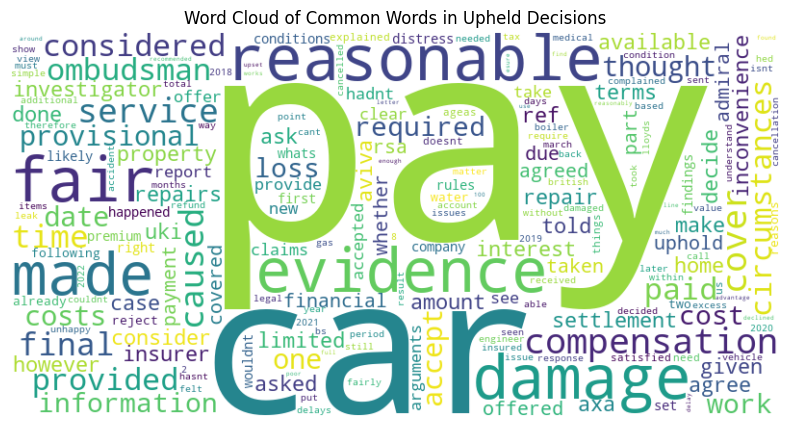

In [10]:
# read insurance_data.csv
insu = pd.read_csv(CSV_FILE)

# filtering data whose decision is Upheld
upheld_decisions = insu[insu['decision'] == 'Upheld']

# get the decision_id of these data
decision_up = upheld_decisions['decision_id'].tolist()

def find_common_words_in_text(text_dir, decision_up):
    """
    Find common words in a given text file.
    """
    common_words = Counter()

    # load stop words
    stop_words_1 = set(stopwords.words('english'))
    
    custom_stop_words_1 = ["mr", "mrs", "ms", "miss", "im", "would", "think", "didnt", "ive", 
                         "dont", "wasnt", "said", "says", "say", "may", "could", "also",
                         "complaint", "claim", "policy", "insurance", "decision"]  
      
    for word in custom_stop_words_1:
        stop_words_1.add(word)
        
    single_letters = set("abcdefghijklmnopqrstuvwxyz")

    for decision_id in decision_up:
        text_file = text_dir / f"{decision_id}.txt"
        if text_file.exists():
            with open(text_file, "r", encoding="utf-8") as file:
                text = file.read()
                words = text.split()  
                words = [word for word in words if word not in stop_words_1 and word not in single_letters]
                common_words.update(words)

    return common_words

# find the text corresponding to decision_up in the insurance_data_txt folder and extract common words.
common_words = find_common_words_in_text(TEXT_DIR, decision_up)

# print the top 50 common words
top_common_words = common_words.most_common(50)
print("Top 50 common words in upheld decisions:")
for idx, (word, count) in enumerate(top_common_words, 1):
    print(f"{word}: {count}", end=' | ' if idx % 5 != 0 else '\n')


# generate a word cloud map
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words)

# show the word cloud map
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words in Upheld Decisions')
plt.show()

Top 50 common words in Not upheld decisions:
cover: 136662 | evidence: 125421 | damage: 124479 | reasonable: 114495 | car: 109662
made: 105179 | fair: 100888 | service: 99765 | ombudsman: 95920 | considered: 87426
final: 85725 | provided: 81343 | circumstances: 79614 | time: 79424 | pay: 75266
information: 69409 | decide: 68006 | accept: 67882 | terms: 66476 | caused: 65343
available: 63651 | uphold: 62484 | required: 59465 | thought: 58402 | told: 57343
ref: 56262 | uki: 55703 | ask: 54959 | insurer: 54809 | asked: 54760
financial: 53515 | aviva: 53290 | covered: 53109 | paid: 52877 | given: 52300
investigator: 52125 | one: 51950 | whether: 51768 | make: 51419 | property: 49177
done: 47654 | rules: 47132 | case: 47060 | axa: 46496 | loss: 45610
claims: 45408 | consider: 45287 | home: 43943 | arguments: 43889 | compensation: 43737


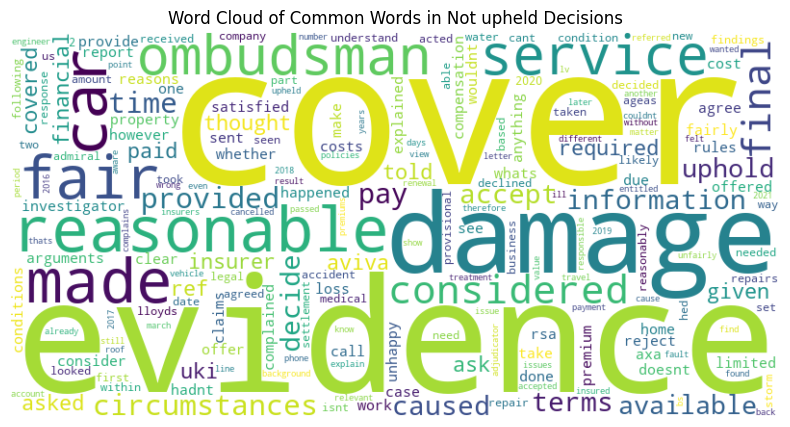

In [11]:
# filtering data whose decision is Not upheld
not_upheld_decisions = insu[insu['decision'] == 'Not upheld']

# get the decision_id of these data
decision_not = not_upheld_decisions['decision_id'].tolist()

def find_common_words_in_text(text_dir, decision_not):
    """
    Find common words in a given text file.
    """
    common_words = Counter()

    # load stop words
    stop_words_2 = set(stopwords.words('english'))
    
    custom_stop_words_2 = ["mr", "mrs", "ms", "miss", "im", "would", "think", "didnt", "ive", 
                         "dont", "wasnt", "said", "says", "say", "may", "could", "also", "b", "c", "h", 
                         "complaint", "claim", "policy", "insurance", "decision"]  
      
    for word in custom_stop_words_2:
        stop_words_2.add(word)
        
    single_letters = set("abcdefghijklmnopqrstuvwxyz")

    for decision_id in decision_not:
        text_file = text_dir / f"{decision_id}.txt"
        if text_file.exists():
            with open(text_file, "r", encoding="utf-8") as file:
                text = file.read()
                words = text.split()  
                words = [word for word in words if word not in stop_words_2 and word not in single_letters]
                common_words.update(words)

    return common_words

# find the text corresponding to decision_not in the insurance_data_txt folder and extract common words.
common_words_not = find_common_words_in_text(TEXT_DIR, decision_not)

# print the top 50 common words
top_common_words = common_words_not.most_common(50)
print("Top 50 common words in Not upheld decisions:")
for idx, (word, count) in enumerate(top_common_words, 1):
    print(f"{word}: {count}", end=' | ' if idx % 5 != 0 else '\n')

# generate a word cloud map
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words_not)

# show the word cloud map
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words in Not upheld Decisions')
plt.show()

### 2.2 A comparison of insurance complaint decisions by different companies

In [12]:
# read the csv file
insu = pd.read_csv(CSV_FILE)

# count the number of appearances per company
company_counts = insu['company'].value_counts()

# extract the top ten companies with the largest number of appearances
top_10_companies = company_counts.head(10).index.tolist()

# initializes the dictionary that stores the results
company_decision_counts = {company: {'Upheld': 0, 'Not upheld': 0} for company in top_10_companies}

# iterate over the data and calculate the number of 'Upheld' and 'Not upheld' for each company
for _, row in insu.iterrows():
    company = row['company']
    decision = row['decision']
    if company in top_10_companies:
        if decision in company_decision_counts[company]:
            company_decision_counts[company][decision] += 1

data_company = []
for company, decisions in company_decision_counts.items():
    data_company.append({
        'Company': company,
        'Upheld': decisions['Upheld'],
        'Not upheld': decisions['Not upheld']
    })

company_output = pd.DataFrame(data_company)
print("Company decision counts:")
print(company_output)



Company decision counts:
                                        Company  Upheld  Not upheld
0                       Aviva Insurance Limited    1014        2384
1                          UK Insurance Limited     995        1981
2                          AXA Insurance UK Plc     949        1710
3                       Ageas Insurance Limited     871        1319
4            Royal & Sun Alliance Insurance Plc     720        1438
5                         U K Insurance Limited     662        1362
6             Admiral Insurance Company Limited     640        1065
7                 British Gas Insurance Limited     756         866
8                       esure Insurance Limited     594         775
9  Liverpool Victoria Insurance Company Limited     348         952


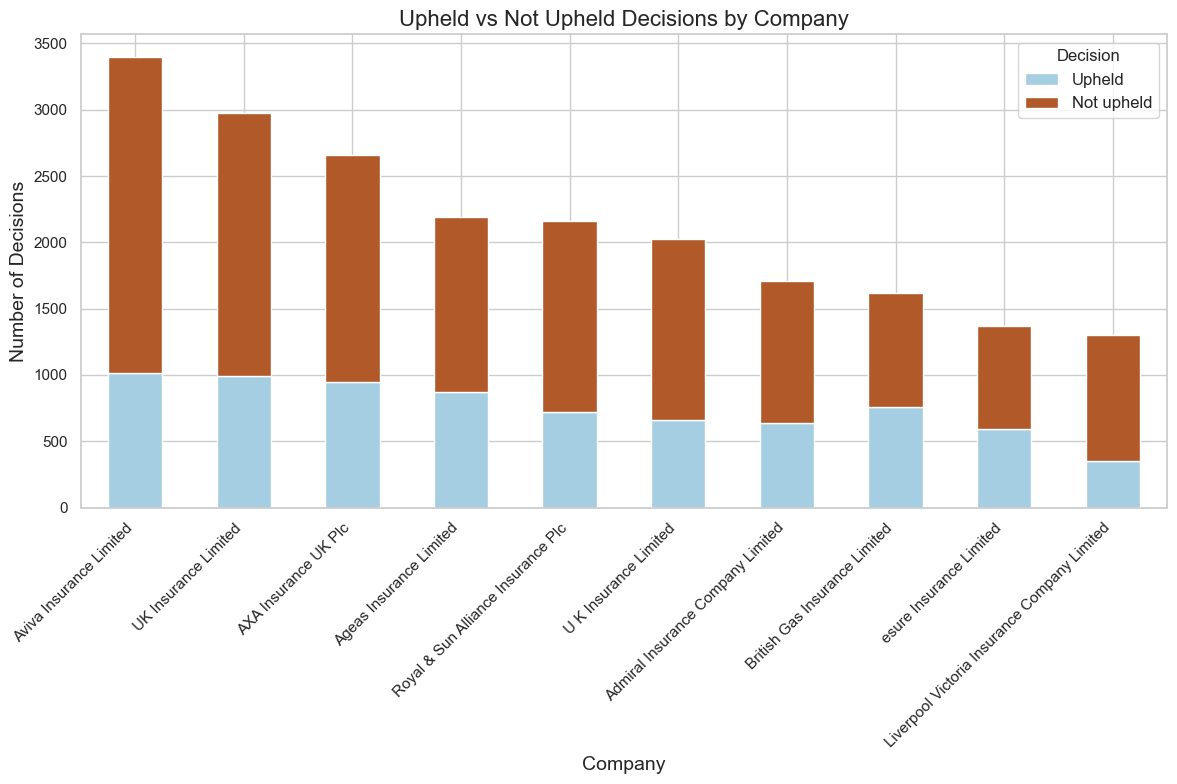

In [13]:
# set the style of the figure
sns.set(style="whitegrid")

# plot bar chart
fig, ax = plt.subplots(figsize=(12, 8))

company_output.set_index('Company').plot(kind='bar', stacked=True, ax=ax, colormap='Paired')

# set the title and labels
ax.set_title('Upheld vs Not Upheld Decisions by Company', fontsize=16)
ax.set_xlabel('Company', fontsize=14)
ax.set_ylabel('Number of Decisions', fontsize=14)
ax.legend(title='Decision', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# show the plot
plt.tight_layout()
plt.show()


### 2.3 Type of Insurance

insurance_type
motor                10937
home                  8733
travel                4647
car                   3221
pet                   1663
medical               1638
legal expenses        1552
buildings             1379
income protection      965
property               725
Name: count, dtype: int64


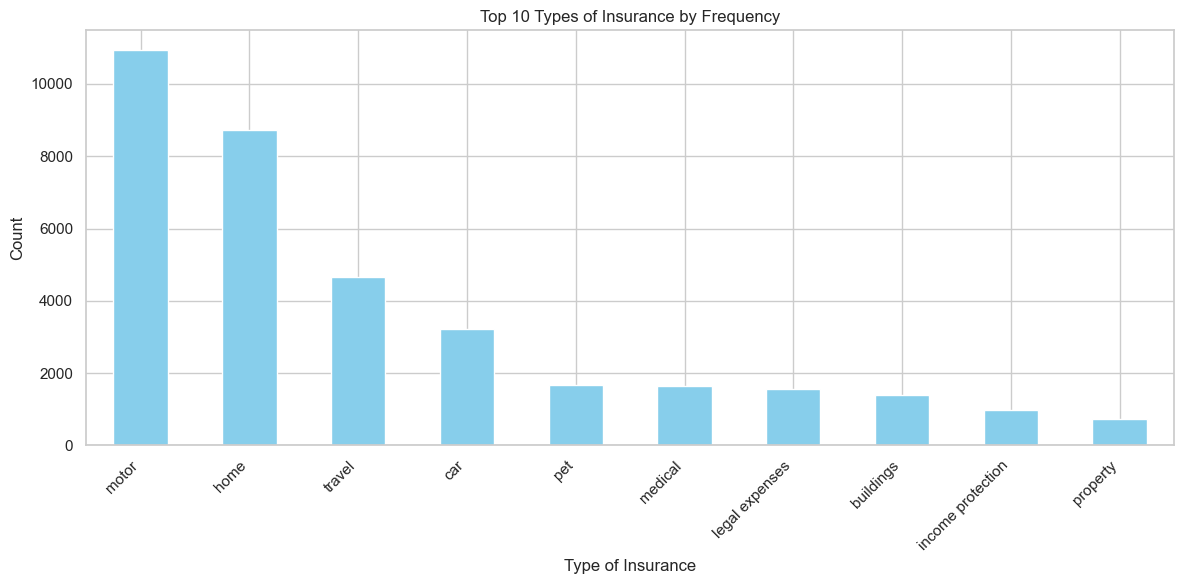

In [14]:
# read the csv file
insu = pd.read_csv(CSV_FILE)

# remove the lines including "sun alliance","NAN", and "u k" of the variable "insurance_type"
filtered_insu = insu[~insu['insurance_type'].isin(['NAN', 'u k','sun alliance'])]

# calculate the top 10 categories that occur most often in 'insurance_type'
top_10_insurance_types = filtered_insu['insurance_type'].value_counts().head(10)

print(top_10_insurance_types)

# plat a bar chart
plt.figure(figsize=(12, 6))
top_10_insurance_types.plot(kind='bar', color='skyblue')
plt.xlabel('Type of Insurance')
plt.ylabel('Count')
plt.title('Top 10 Types of Insurance by Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 2.4 changes in keywords in complaints through different insurance type

In [15]:
# set the path
KEYWORDS_FILE = 'keywords_per_document.csv'

top_10_types = top_10_insurance_types.index.tolist()

# read the csv file
keywords_df = pd.read_csv(KEYWORDS_FILE)

# initialize the dictionary that stores the results
type_keywords = {insurance_type: [] for insurance_type in top_10_types}

# iterate through the keyword data to extract keywords for each insurance type
for index, row in keywords_df.iterrows():
    ins_type = filtered_insu.loc[filtered_insu['decision_id'] == row['decision_id'], 'insurance_type'].values
    if ins_type.size > 0:
        ins_type = ins_type[0]
        if ins_type in top_10_types:
            # get the top 30 keywords
            for i in range(1, 31):
                keyword = row.get(f'keyword{i}')
                if pd.notna(keyword):
                    type_keywords[ins_type].append(keyword)

# calculate the 10 most common keywords under each insurance type
top_keywords_by_type = {}
for ins_type, keywords in type_keywords.items():
    most_common_keywords = Counter(keywords).most_common(10)
    top_keywords_by_type[ins_type] = [keyword for keyword, _ in most_common_keywords]


data_type = []
for ins_type, keywords in top_keywords_by_type.items():
    row = {'Insurance Type': ins_type}
    # add the first 10 keywords
    for i, keyword in enumerate(keywords[:10]):
        row[f'Keyword {i + 1}'] = keyword
    # add them to the list
    data_type.append(row)

# convert to a DataFrame
keywords_output = pd.DataFrame(data_type)

print(keywords_output)

      Insurance Type Keyword 1   Keyword 2 Keyword 3   Keyword 4 Keyword 5  \
0              motor       car      policy     claim       motor  accident   
1               home     claim        home    damage      policy     water   
2             travel    travel       claim    policy        trip   medical   
3                car       car      policy     claim    accident  incident   
4                pet       pet      policy       dog         vet     claim   
5            medical   medical     private    policy   treatment       axa   
6     legal expenses     legal       claim  expenses  solicitors    policy   
7          buildings     claim      damage  property   buildings    policy   
8  income protection    income  protection    policy        work   benefit   
9           property  property       claim    damage      policy      loss   

   Keyword 6   Keyword 7  Keyword 8  Keyword 9    Keyword 10  
0    premium   cancelled    vehicle     driver       admiral  
1   property   

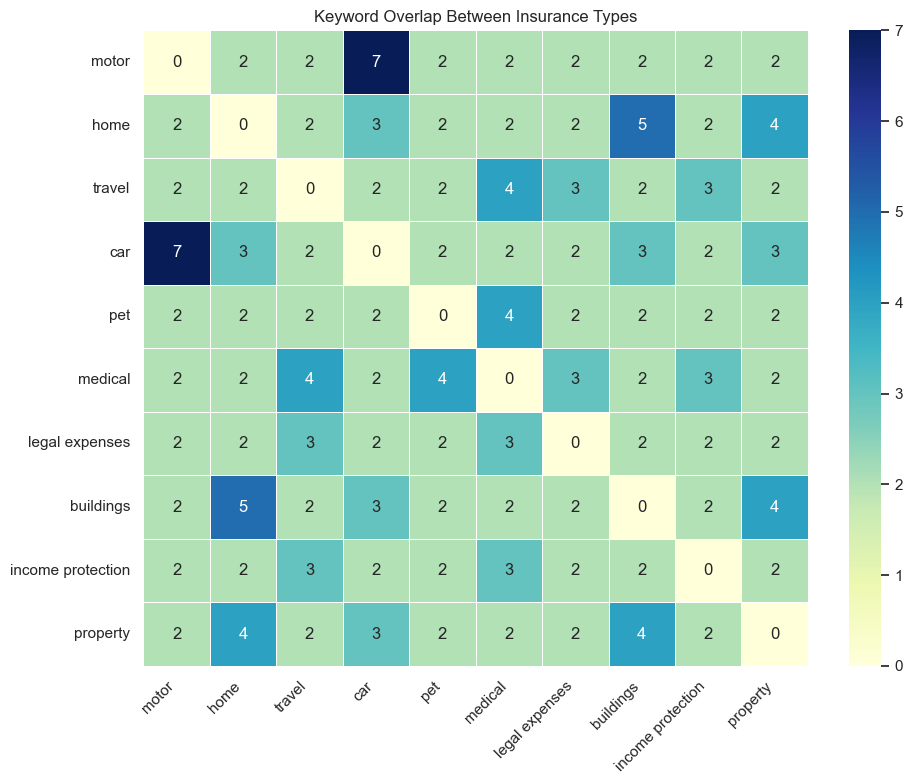

In [16]:
# calculate a keyword set for each insurance type
keyword_sets = {ins_type: set(keywords) for ins_type, keywords in top_keywords_by_type.items()}

# create an empty DataFrame to store the coincidence
overlap_matrix = pd.DataFrame(index=top_10_types, columns=top_10_types).fillna(0)

# filled coincidence matrix
for ins_type1 in top_10_types:
    for ins_type2 in top_10_types:
        if ins_type1 == ins_type2:
            continue
        overlap = len(keyword_sets[ins_type1].intersection(keyword_sets[ins_type2]))
        overlap_matrix.loc[ins_type1, ins_type2] = overlap


# plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix.astype(int), cmap="YlGnBu", annot=True, fmt="d", linewidths=.5)
plt.title('Keyword Overlap Between Insurance Types')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 2.5 changes in keywords in complaints through time

In [17]:
# read the csv file
keywords_df = pd.read_csv('keywords_per_document.csv')

# classify the year
def categorize_year(date_str):
    if '2015' in date_str:
        return 2015
    elif '2016' in date_str:
        return 2016
    elif '2017' in date_str:
        return 2017
    elif '2018' in date_str:
        return 2018
    elif '2019' in date_str:
        return 2019
    elif '2020' in date_str:
        return 2020
    elif '2021' in date_str:
        return 2021
    elif '2022' in date_str:
        return 2022
    elif '2023' in date_str:
        return 2023
    elif '2024' in date_str:
        return 2024
    else:
        return 'Unknown'

# add a new variable "year"
keywords_df['year'] = keywords_df['date'].apply(categorize_year)

# save it in the csv
keywords_df.to_csv('keywords_per_document.csv', index=False)

print("Updated CSV with 'year' column saved.")

Updated CSV with 'year' column saved.


In [18]:
# read the csv file
keywords_df = pd.read_csv('keywords_per_document.csv')

# make sure the 'year' column is included in the data
if 'year' not in keywords_df.columns:
    raise ValueError("The 'year' column is missing in the data. Please add it before proceeding.")

# initialize the dictionary that stores the results
year_keywords = {}

# collect keywords by year
for year in keywords_df['year'].unique():
    
    # filter out data for specific years
    year_data = keywords_df[keywords_df['year'] == year]
    
    # collect the keywords
    keywords = []
    for index, row in year_data.iterrows():
        for i in range(1, 31):  # keyword 1 to keyword 30
            keyword = row.get(f'keyword{i}')
            if pd.notna(keyword):
                keywords.append(keyword)
    
    # calculate the 10 most common keywords each year
    keyword_counts = Counter(keywords)
    most_common_keywords = keyword_counts.most_common(10)
    year_keywords[year] = [keyword for keyword, _ in most_common_keywords]

# create a list
data_year = []

for year, keywords in year_keywords.items():
    row = {'Year': year}
    for i, keyword in enumerate(keywords):
        row[f'Keyword {i + 1}'] = keyword
    data_year.append(row)

# convert to a DataFrame
keywords_output_year = pd.DataFrame(data_year)

print(keywords_output_year)


   Year Keyword 1 Keyword 2    Keyword 3 Keyword 4 Keyword 5 Keyword 6  \
0  2019     claim    policy          car    damage     cover   premium   
1  2020     claim    policy          car    damage  property      home   
2  2021     claim    policy       damage       car     cover  property   
3  2022     claim    policy       damage       car     cover  property   
4  2023     claim    policy          car    damage     cover  declined   
5  2024     claim    policy          car    damage  property     cover   
6  2016     claim    policy  adjudicator       car    damage       pay   
7  2015     claim    policy  adjudicator       car    damage  decision   
8  2018     claim    policy          car    damage     cover       uki   
9  2017     claim    policy          car    damage     cover       pay   

      Keyword 7    Keyword 8   Keyword 9    Keyword 10  
0      accident         home         uki      property  
1         cover        water    accident       premium  
2        trave

In [19]:
# initialize the dictionary that stores the results
year_keywords_1 = {}

# traverse the data and collect keywords by year
for year in keywords_df['year'].unique():
    year_data = keywords_df[keywords_df['year'] == year]
    
    keywords = set()
    for index, row in year_data.iterrows():
        for i in range(1, 31): 
            keyword = row.get(f'keyword{i}')
            if pd.notna(keyword):
                keywords.add(keyword)
    
    year_keywords_1[year] = keywords

# calculate the Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# calculate the coincidence between years
years = list(year_keywords_1.keys())
similarity_matrix = pd.DataFrame(index=years, columns=years)

for i in range(len(years)):
    for j in range(len(years)):
        if i <= j:
            similarity = jaccard_similarity(year_keywords_1[years[i]], year_keywords_1[years[j]])
            similarity_matrix.iloc[i, j] = similarity
            similarity_matrix.iloc[j, i] = similarity

print("Yearly keyword similarity matrix:")
print(similarity_matrix)


Yearly keyword similarity matrix:
          2019      2020      2021      2022      2023      2024      2016  \
2019       1.0  0.527139  0.525285  0.516809  0.510749  0.486177   0.52343   
2020  0.527139       1.0  0.534087  0.521686  0.522375  0.474169  0.516406   
2021  0.525285  0.534087       1.0  0.535276  0.531203  0.475204  0.509641   
2022  0.516809  0.521686  0.535276       1.0  0.528078  0.480779  0.503751   
2023  0.510749  0.522375  0.531203  0.528078       1.0  0.484207  0.498896   
2024  0.486177  0.474169  0.475204  0.480779  0.484207       1.0  0.490331   
2016   0.52343  0.516406  0.509641  0.503751  0.498896  0.490331       1.0   
2015   0.52422  0.514596  0.511567  0.500343  0.501562  0.478401  0.535274   
2018  0.532178  0.522148  0.517112  0.506258  0.511448  0.489123  0.532229   
2017  0.532627  0.522393  0.515694    0.5078  0.510705  0.492531  0.539125   

          2015      2018      2017  
2019   0.52422  0.532178  0.532627  
2020  0.514596  0.522148  0.52239

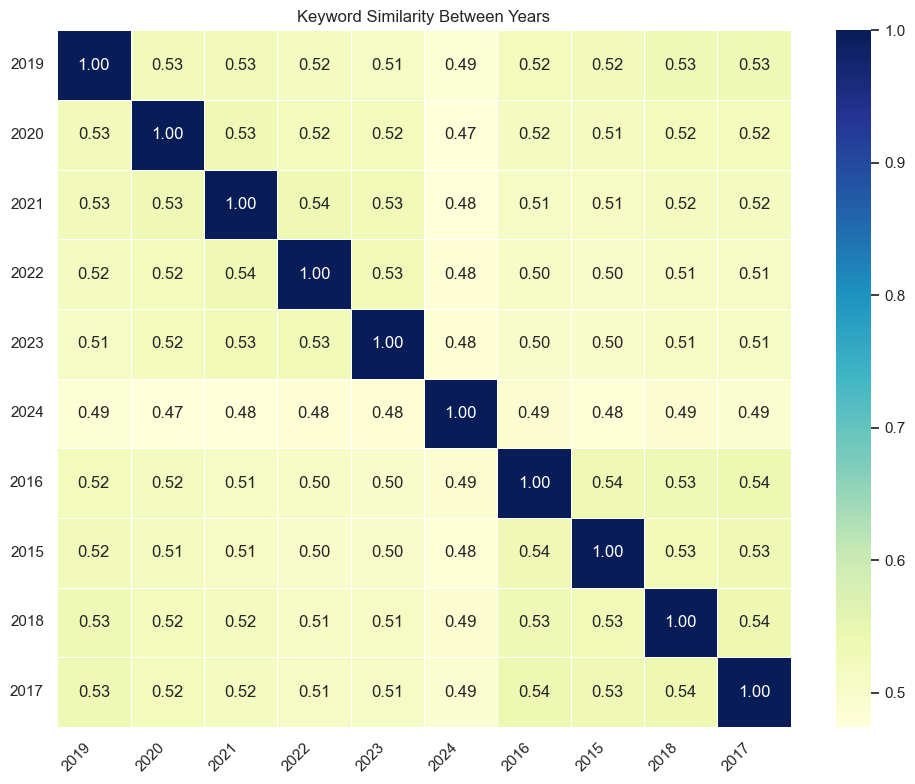

In [20]:
# plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.astype(float), cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
plt.title('Keyword Similarity Between Years')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 2.6  changes in keywords in complaints of different decisions

In [21]:
# set the path
KEYWORDS_FILE = 'keywords_per_document.csv'

# read the csv file
keywords_df = pd.read_csv(KEYWORDS_FILE)

# initialize the dictionary that stores the results
decision_keywords = {}

# iterate through the keyword data to extract keywords for each decision
for index, row in keywords_df.iterrows():
    decision = row['decision']
    if decision not in decision_keywords:
        decision_keywords[decision] = []
    # get the top 30 keywords
    for i in range(1, 31):
        keyword = row.get(f'keyword{i}')
        if pd.notna(keyword):
            decision_keywords[decision].append(keyword)

# calculate the 10 most common keywords under each decision
top_keywords_by_decision = {}
for decision, keywords in decision_keywords.items():
    most_common_keywords = Counter(keywords).most_common(10)
    top_keywords_by_decision[decision] = [keyword for keyword, _ in most_common_keywords]

# prepare data for DataFrame
data_decision = []
for decision, keywords in top_keywords_by_decision.items():
    row = {'Decision': decision}
    # add the first 10 keywords
    for i, keyword in enumerate(keywords[:10]):
        row[f'Keyword {i + 1}'] = keyword
    # add them to the list
    data_decision.append(row)

# convert to a DataFrame
keywords_output_decision = pd.DataFrame(data_decision)

print(keywords_output_decision)


     Decision Keyword 1 Keyword 2 Keyword 3 Keyword 4     Keyword 5 Keyword 6  \
0      Upheld     claim    policy       car    damage  compensation       pay   
1  Not upheld     claim    policy       car    damage         cover  property   

  Keyword 7 Keyword 8 Keyword 9 Keyword 10  
0  property     cover   repairs       home  
1      home  accident  declined    premium  


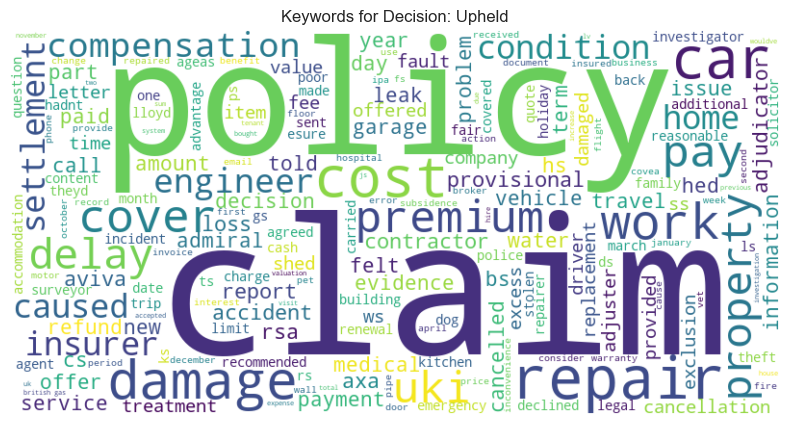

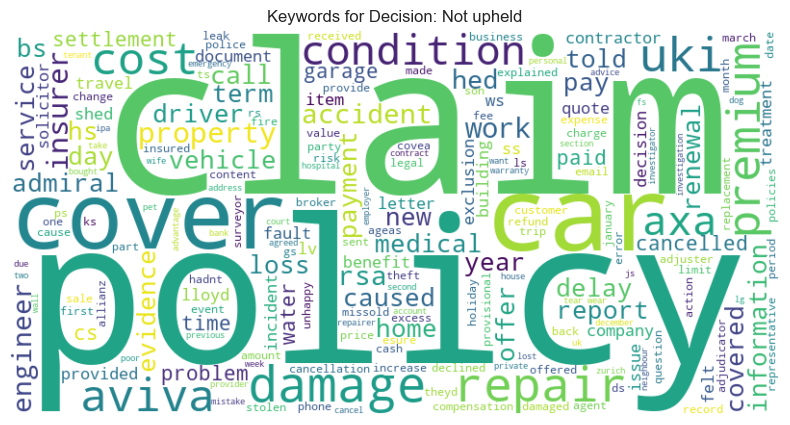

In [23]:
# plot the wordcloud
for decision, keyword_counts in top_keywords_by_decision.items():
    all_keywords = ' '.join(decision_keywords[decision])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Keywords for Decision: {decision}")
    plt.axis('off')
    plt.show()


### 2.7 Reasons of different decisions

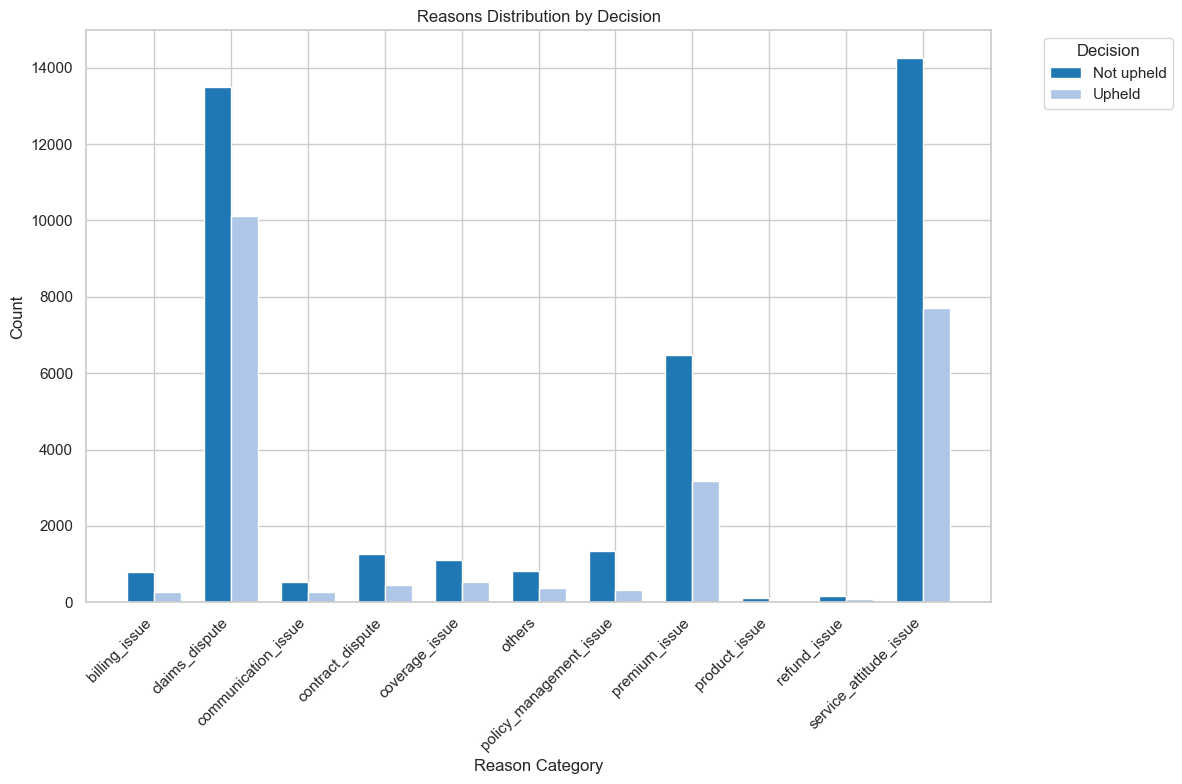

Plot has been saved as all_reasons_by_decision.png.


In [24]:
# read the csv file
reason_df = pd.read_csv("reason.csv")

# count the number of reasons under each decision category
decision_groups = reason_df.groupby(['decision', 'reason']).size().unstack(fill_value=0)

# ensure all indexes and column names are strings
decision_groups.index = decision_groups.index.astype(str)
decision_groups.columns = decision_groups.columns.astype(str)

# plot the reason statistics for all decision categories
plt.figure(figsize=(12, 8))

# choose different colors
colors = plt.get_cmap('tab20').colors

# plot a bar chart for each decision category
bar_width = 0.35
x = range(len(decision_groups.columns))  # the X-axis position

for i, decision in enumerate(decision_groups.index):
    plt.bar([p + i * bar_width for p in x], decision_groups.loc[decision], width=bar_width, label=decision, color=colors[i % len(colors)])

plt.title('Reasons Distribution by Decision')
plt.xlabel('Reason Category')
plt.ylabel('Count')
plt.xticks([p + bar_width * (len(decision_groups.index) / 2 - 0.5) for p in x], decision_groups.columns, rotation=45, ha='right')
plt.legend(title='Decision', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('all_reasons_by_decision.jpg')  # Save the plot as a PNG file
plt.show()

print("Plot has been saved as all_reasons_by_decision.png.")




# 3 Build the Models (TF-IDF)

### 3.1 Logistic Model

In [3]:
# Ten fold cross verification of logistic regression model

# read the csv file
insu_im = pd.read_csv('important_words.csv')

# choose the explanatory variables（form column 1 to column 3200）
X = insu_im.iloc[:, 0:3200]  

# choose the response variable
y = insu_im['decision_y']

# convert 'Upheld' to 1 and 'Not upheld' to 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# make sure that the converted y is numeric
y = y.astype(int)

# define the preprocess steps (standardize all numerical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)  
    ]
)

# create a logistic regression model
model = LogisticRegression(max_iter=1000)

# create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# define evaluation indicators
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# ten fold cross verification
cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=False)

# print detailed values and averages for each metric
metrics = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
for metric in metrics:
    scores = cv_results[f'test_{metric}']
    avg_score = np.mean(scores)
    
    print(f"\n{metric.capitalize()}:")
    for i, score in enumerate(scores):
        print(f"Fold {i+1}: {score:.4f}")
    print(f"Average: {avg_score:.4f}")



Accuracy:
Fold 1: 0.8070
Fold 2: 0.8147
Fold 3: 0.8211
Fold 4: 0.8229
Fold 5: 0.8093
Fold 6: 0.7639
Fold 7: 0.7685
Fold 8: 0.7652
Fold 9: 0.7641
Fold 10: 0.7660
Average: 0.7903

Precision:
Fold 1: 0.8023
Fold 2: 0.7966
Fold 3: 0.7807
Fold 4: 0.7648
Fold 5: 0.7460
Fold 6: 0.7322
Fold 7: 0.7394
Fold 8: 0.7211
Fold 9: 0.7139
Fold 10: 0.7179
Average: 0.7515

F1:
Fold 1: 0.7043
Fold 2: 0.7237
Fold 3: 0.7443
Fold 4: 0.7552
Fold 5: 0.7362
Fold 6: 0.6348
Fold 7: 0.6424
Fold 8: 0.6460
Fold 9: 0.6483
Fold 10: 0.6504
Average: 0.6886

Recall:
Fold 1: 0.6277
Fold 2: 0.6631
Fold 3: 0.7111
Fold 4: 0.7458
Fold 5: 0.7265
Fold 6: 0.5602
Fold 7: 0.5679
Fold 8: 0.5851
Fold 9: 0.5937
Fold 10: 0.5945
Average: 0.6376

Roc_auc:
Fold 1: 0.8610
Fold 2: 0.8641
Fold 3: 0.8744
Fold 4: 0.8809
Fold 5: 0.8654
Fold 6: 0.8250
Fold 7: 0.8310
Fold 8: 0.8235
Fold 9: 0.8255
Fold 10: 0.8248
Average: 0.8476


### 3.2 Random Forest Model

In [4]:
# Ten fold cross verification of random forest model

# read the csv file
insu_im = pd.read_csv('important_words.csv')

# choose the explanatory variables（form column 1 to column 3000）
X = insu_im.iloc[:, 0:3200]  

# choose the response variable
#y = insu_im['decision_y']
y = insu_im.iloc[:, -1]

# convert 'Upheld' to 1 and 'Not upheld' to 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# make sure that the converted y is numeric
y = y.astype(int)

# define the preprocess steps (standardize all numerical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)  
    ]
)

# create a random forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# define evaluation indicators
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# ten fold cross verification
cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=False)

# print detailed values and averages for each metric
metrics = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
for metric in metrics:
    scores = cv_results[f'test_{metric}']
    avg_score = np.mean(scores)
    
    print(f"\n{metric.capitalize()}:")
    for i, score in enumerate(scores):
        print(f"Fold {i+1}: {score:.4f}")
    print(f"Average: {avg_score:.4f}")


Accuracy:
Fold 1: 0.8178
Fold 2: 0.8203
Fold 3: 0.8198
Fold 4: 0.8288
Fold 5: 0.8214
Fold 6: 0.7748
Fold 7: 0.7733
Fold 8: 0.7737
Fold 9: 0.7620
Fold 10: 0.7765
Average: 0.7968

Precision:
Fold 1: 0.8350
Fold 2: 0.8024
Fold 3: 0.7839
Fold 4: 0.7867
Fold 5: 0.7664
Fold 6: 0.7540
Fold 7: 0.7521
Fold 8: 0.7402
Fold 9: 0.7214
Fold 10: 0.7411
Average: 0.7683

F1:
Fold 1: 0.7158
Fold 2: 0.7335
Fold 3: 0.7403
Fold 4: 0.7575
Fold 5: 0.7513
Fold 6: 0.6501
Fold 7: 0.6475
Fold 8: 0.6557
Fold 9: 0.6371
Fold 10: 0.6624
Average: 0.6951

Recall:
Fold 1: 0.6264
Fold 2: 0.6755
Fold 3: 0.7012
Fold 4: 0.7304
Fold 5: 0.7368
Fold 6: 0.5714
Fold 7: 0.5684
Fold 8: 0.5885
Fold 9: 0.5705
Fold 10: 0.5988
Average: 0.6368

Roc_auc:
Fold 1: 0.8891
Fold 2: 0.8955
Fold 3: 0.8908
Fold 4: 0.9002
Fold 5: 0.8851
Fold 6: 0.8544
Fold 7: 0.8525
Fold 8: 0.8517
Fold 9: 0.8396
Fold 10: 0.8477
Average: 0.8707


# 4. Build the Model (chi-square test)

### 4.1 Logistic regression model 

In [5]:
# Ten fold cross verification of logistic regression model

# read the csv file
insu_sig = pd.read_csv('significant_words.csv')

# choose the explanatory variables（form column 1 to column 3362）
X = insu_sig.iloc[:, 0:3362]  

# choose the response variable
y = insu_sig.iloc[:, -1]   

# convert 'Upheld' to 1 and 'Not upheld' to 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# make sure that the converted y is numeric
y = y.astype(int)

# define the preprocess steps (standardize all numerical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)  
    ]
)

# create a logistic regression model
model = LogisticRegression(max_iter=1000)

# create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# define evaluation indicators
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# ten fold cross verification
cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=False)

# print detailed values and averages for each metric
metrics = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
for metric in metrics:
    scores = cv_results[f'test_{metric}']
    avg_score = np.mean(scores)
    
    print(f"\n{metric.capitalize()}:")
    for i, score in enumerate(scores):
        print(f"Fold {i+1}: {score:.4f}")
    print(f"Average: {avg_score:.4f}")


Accuracy:
Fold 1: 0.7943
Fold 2: 0.8123
Fold 3: 0.8139
Fold 4: 0.8182
Fold 5: 0.8060
Fold 6: 0.7608
Fold 7: 0.7594
Fold 8: 0.7625
Fold 9: 0.7592
Fold 10: 0.7631
Average: 0.7850

Precision:
Fold 1: 0.7866
Fold 2: 0.7932
Fold 3: 0.7689
Fold 4: 0.7633
Fold 5: 0.7439
Fold 6: 0.7256
Fold 7: 0.7252
Fold 8: 0.7197
Fold 9: 0.7104
Fold 10: 0.7139
Average: 0.7451

F1:
Fold 1: 0.6817
Fold 2: 0.7200
Fold 3: 0.7344
Fold 4: 0.7463
Fold 5: 0.7302
Fold 6: 0.6306
Fold 7: 0.6269
Fold 8: 0.6397
Fold 9: 0.6375
Fold 10: 0.6457
Average: 0.6793

Recall:
Fold 1: 0.6015
Fold 2: 0.6592
Fold 3: 0.7030
Fold 4: 0.7300
Fold 5: 0.7171
Fold 6: 0.5577
Fold 7: 0.5521
Fold 8: 0.5757
Fold 9: 0.5782
Fold 10: 0.5894
Average: 0.6264

Roc_auc:
Fold 1: 0.8375
Fold 2: 0.8611
Fold 3: 0.8691
Fold 4: 0.8719
Fold 5: 0.8592
Fold 6: 0.8204
Fold 7: 0.8184
Fold 8: 0.8230
Fold 9: 0.8203
Fold 10: 0.8209
Average: 0.8402


### 4.2 Random Forest model

In [6]:
# Ten fold cross verification of random forest model

# read the csv file
insu_sig = pd.read_csv('significant_words.csv')

# choose the explanatory variables（form column 1 to column 3362）
X = insu_sig.iloc[:, 0:3362]  

# choose the response variable
y = insu_sig.iloc[:, -1]   # the last column

# convert 'Upheld' to 1 and 'Not upheld' to 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# make sure that the converted y is numeric
y = y.astype(int)

# define the preprocess steps (standardize all numerical features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)  
    ]
)

# create a random forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# define evaluation indicators
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# ten fold cross verification
cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=False)

# print detailed values and averages for each metric
metrics = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
for metric in metrics:
    scores = cv_results[f'test_{metric}']
    avg_score = np.mean(scores)
    
    print(f"\n{metric.capitalize()}:")
    for i, score in enumerate(scores):
        print(f"Fold {i+1}: {score:.4f}")
    print(f"Average: {avg_score:.4f}")


Accuracy:
Fold 1: 0.8131
Fold 2: 0.8230
Fold 3: 0.8231
Fold 4: 0.8269
Fold 5: 0.8229
Fold 6: 0.7705
Fold 7: 0.7740
Fold 8: 0.7672
Fold 9: 0.7598
Fold 10: 0.7741
Average: 0.7955

Precision:
Fold 1: 0.8268
Fold 2: 0.8076
Fold 3: 0.7874
Fold 4: 0.7803
Fold 5: 0.7684
Fold 6: 0.7454
Fold 7: 0.7582
Fold 8: 0.7317
Fold 9: 0.7183
Fold 10: 0.7363
Average: 0.7660

F1:
Fold 1: 0.7083
Fold 2: 0.7372
Fold 3: 0.7457
Fold 4: 0.7564
Fold 5: 0.7536
Fold 6: 0.6441
Fold 7: 0.6455
Fold 8: 0.6441
Fold 9: 0.6333
Fold 10: 0.6594
Average: 0.6927

Recall:
Fold 1: 0.6195
Fold 2: 0.6781
Fold 3: 0.7081
Fold 4: 0.7338
Fold 5: 0.7394
Fold 6: 0.5671
Fold 7: 0.5619
Fold 8: 0.5752
Fold 9: 0.5662
Fold 10: 0.5971
Average: 0.6346

Roc_auc:
Fold 1: 0.8835
Fold 2: 0.8942
Fold 3: 0.8907
Fold 4: 0.8957
Fold 5: 0.8864
Fold 6: 0.8497
Fold 7: 0.8510
Fold 8: 0.8460
Fold 9: 0.8357
Fold 10: 0.8430
Average: 0.8676
